<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg">

## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course

Author: [Yury Kashnitsky](https://www.linkedin.com/in/festline). Translated and edited by [Christina Butsko](https://www.linkedin.com/in/christinabutsko/), [Nerses Bagiyan](https://www.linkedin.com/in/nersesbagiyan/), [Yulia Klimushina](https://www.linkedin.com/in/yuliya-klimushina-7168a9139), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-commercial purpose.

*You can also check out the latest version of this notebook in the [course repository](https://github.com/Yorko/mlcourse.ai), and the corresponding video lectures: [theoretical part](https://www.youtube.com/watch?v=l3jiw-N544s), [practical part](https://www.youtube.com/watch?v=7o0SWgY89i8).*

# <center>Topic 4. Linear Classification and Regression
## <center> Part 3. An Illustrative Example of Logistic Regression Regularization

In the first article, we demonstrated how polynomial features allow linear models to build nonlinear separating surfaces. Let's now show this visually.

Let's see how regularization affects the quality of classification on a dataset on microchip testing from Andrew Ng's course on machine learning. We will use logistic regression with polynomial features and vary the regularization parameter $C$. First, we will see how regularization affects the separating border of the classifier and intuitively recognize under- and overfitting. Then, we will choose the regularization parameter to be numerically close to the optimal value via (`cross-validation`) and (`GridSearch`).

In [1]:
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

Let's load the data using `read_csv` from the `pandas` library. In this dataset on 118 microchips (objects), there are results for two tests of quality control (two numerical variables) and information whether the microchip went into production. Variables are already centered, meaning that the column values have had their own mean values subtracted. Thus, the "average" microchip corresponds to a zero value in the test results.  

In [2]:
# loading data
data = pd.read_csv('../input/microchip_tests.txt',
                   header=None, names = ('test1','test2','released'))
# getting some info about dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
released    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


Let's inspect at the first and last 5 lines.

In [3]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
data.tail(5)

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


Now we should save the training set and the target class labels in separate NumPy arrays.

In [5]:
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

As an intermediate step, we can plot the data. Orange points correspond to defective chips, blue to normal ones.

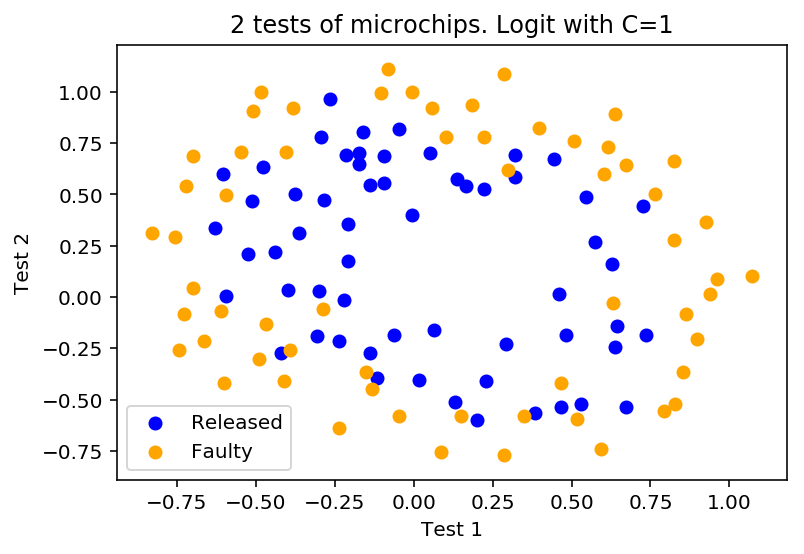

In [6]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=1')
plt.legend();

Let's define a function to display the separating curve of the classifier.

In [7]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

We define the following polynomial features of degree $d$ for two variables $x_1$ and $x_2$:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$

For example, for $d=3$, this will be the following features:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

Drawing a Pythagorean Triangle would show how many of these features there will be for $d=4,5...$ and so on.
The number of such features is exponentially large, and it can be costly to build polynomial features of large degree (e.g $d=10$) for 100 variables. More importantly, it's not needed. 


We will use `sklearn`'s implementation of logistic regression. So, we create an object that will add polynomial features up to degree 7 to matrix $X$.

In [8]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [9]:
X_poly.shape

(118, 36)

Let's train logistic regression with regularization parameter $C = 10^{-2}$.

Accuracy on training set: 0.627


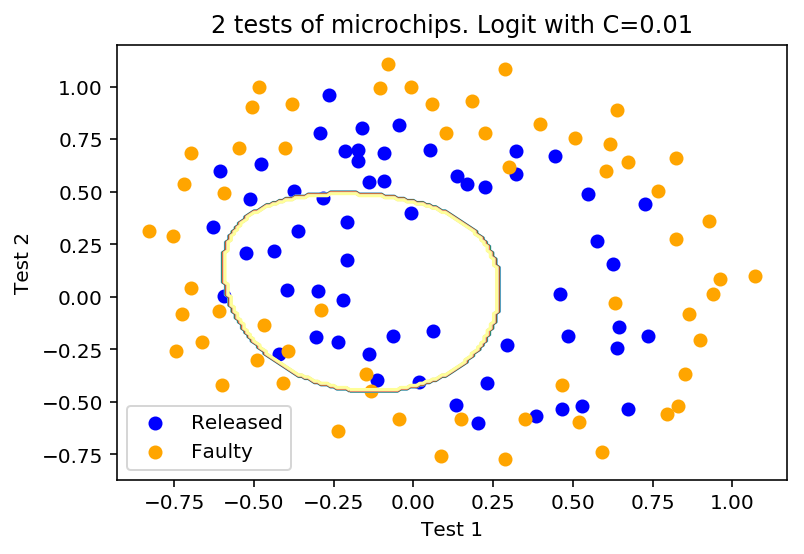

In [10]:
C = 1e-2
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_poly, y), 3))

We could now try increasing $C$ to 1. In doing this, we weaken regularization, and the solution can now have greater values (in absolute value) of model weights than previously. Now the accuracy of the classifier on the training set improves to 0.831.

Accuracy on training set: 0.831


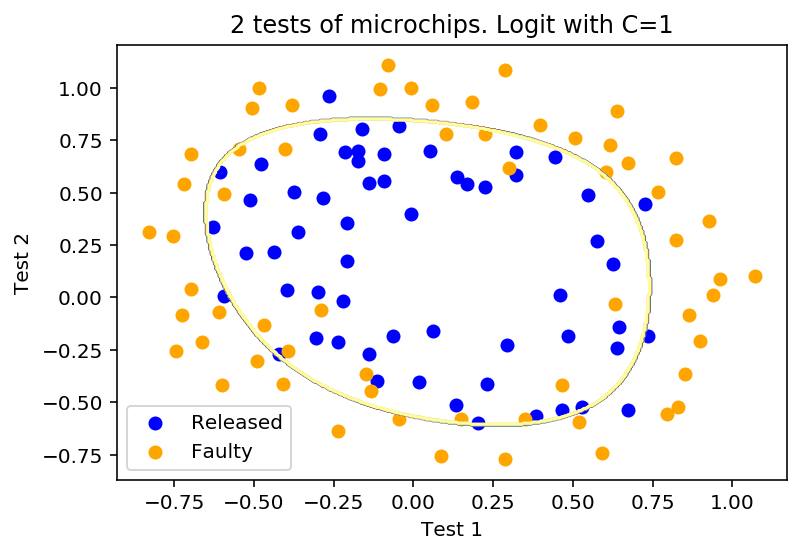

In [11]:
C = 1
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_poly, y), 3))

Then, why don't we increase $C$ even more - up to 10,000? Now, regularization is clearly not strong enough, and we see overfitting. Note that, with $C$=1 and a "smooth" boundary, the share of correct answers on the training set is not much lower than here. But one can easily imagine how our second model will work much better on new data.

Accuracy on training set: 0.873


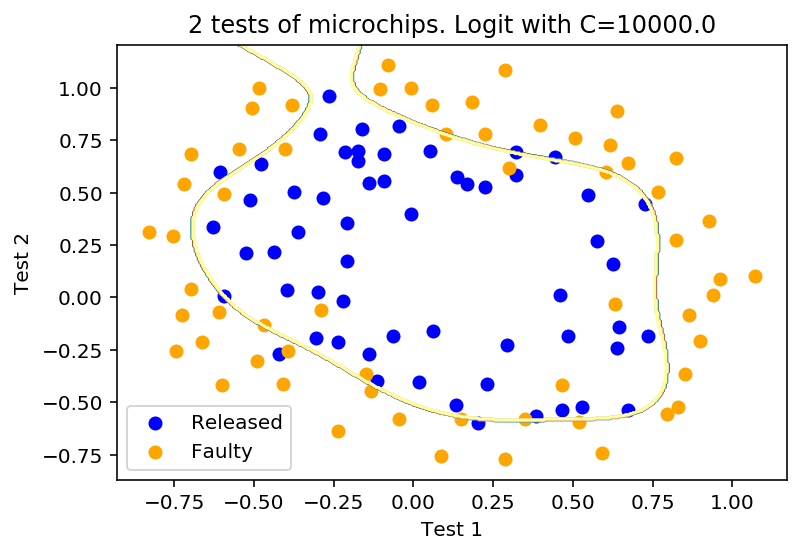

In [12]:
C = 1e4
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_poly, y), 3))

To discuss the results, let's rewrite the function that is optimized in logistic regression with the form:

$$\large J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

where

- $\mathcal{L}$ is the logistic loss function summed over the entire dataset
- $C$ is the reverse regularization coefficient (the very same $C$ from `sklearn`'s implementation of `LogisticRegression`)

**Conclusions**:
- the larger the parameter $C$, the more complex the relationships in the data that the model can recover (intuitively $C$ corresponds to the "complexity" of the model - model capacity)
- if regularization is too strong i.e. the values of $C$ are small, the solution to the problem of minimizing the logistic loss function may be the one where many of the weights are too small or zeroed. The model is also not sufficiently "penalized" for errors (i.e. in the function $J$, the sum of the squares of the weights "outweighs", and the error $\mathcal{L}$ can be relatively large). In this case, the model will underfit as we saw in our first case.
- on the contrary, if regularization is too weak i.e. the values of $C$ are large, a vector $w$ with high absolute value components can become the solution to the optimization problem. In this case, $\mathcal{L}$ has a greater contribution to the optimized functional $J$. Loosely speaking, the model is too "afraid" to be mistaken on the objects from the training set and will therefore overfit as we saw in the third case.
- logistic regression will not "understand" (or "learn") what value of $C$ to choose as it does with the weights $w$. That is to say, it can not be determined by solving the optimization problem in logistic regression. We have seen a similar situation before -- a decision tree can not "learn" what depth limit to choose during the training process. Therefore, $C$ is the a model hyperparameter that is tuned on cross-validation; so is the max_depth in a tree.

**Regularization parameter tuning**

Using this example, let's identify the optimal value of the regularization parameter $C$. This can be done using `LogisticRegressionCV` - a grid search of parameters followed by cross-validation. This class is designed specifically for logistic regression (effective algorithms with well-known search parameters). For an arbitrary model, use `GridSearchCV`, `RandomizedSearchCV`, or special algorithms for hyperparameter optimization such as the one implemented in `hyperopt`.

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.0s finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62...
       8.50863158e+02, 8.70722485e+02, 8.91045332e+02, 9.11842520e+02,
       9.33125118e+02, 9.54904456e+02, 9.77192128e+02, 1.00000000e+03]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='warn',
                     n_jobs=-1, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=1)

In [14]:
logit_searcher.C_

array([5.43839743])

To see how the quality of the model (percentage of correct responses on the training and validation sets) varies with the hyperparameter $C$, we can plot the graph. 

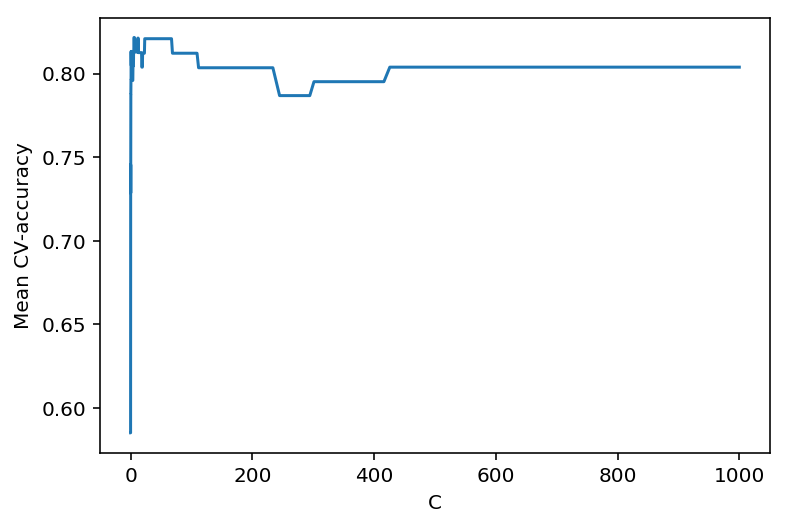

In [15]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');

Finally, select the area with the "best" values of $C$.

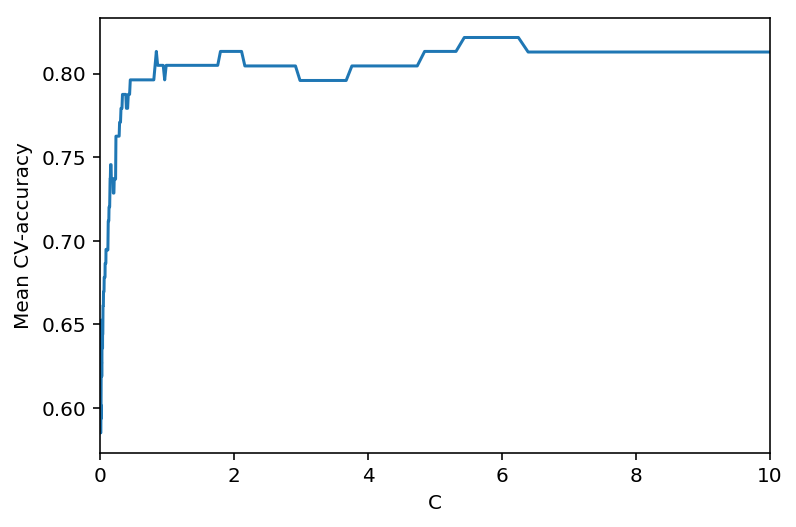

In [16]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');
plt.xlim((0,10));

Recall that these curves are called validation curves. Previously, we built them manually, but sklearn has special methods to construct these that we will use going forward.

### Demo assignment
To practice with linear models, you can complete [this assignment](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit) where you'll build a sarcasm detection model. The assignment is just for you to practice, and goes with [solution](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution).

### Useful resources
- Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-4-linear-classification-and-regression-44a41b9b5220) based on this notebook
- Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- If you read Russian: an [article](https://habrahabr.ru/company/ods/blog/323890/) on Habr.com with ~ the same material. And a [lecture](https://youtu.be/oTXGQ-_oqvI) on YouTube
- A nice and concise overview of linear models is given in the book ["Deep Learning"](http://www.deeplearningbook.org) (I. Goodfellow, Y. Bengio, and A. Courville).
- Linear models are covered practically in every ML book. We recommend "Pattern Recognition and Machine Learning" (C. Bishop) and "Machine Learning: A Probabilistic Perspective" (K. Murphy).
- If you prefer a thorough overview of linear model from a statistician's viewpoint, then look at "The elements of statistical learning" (T. Hastie, R. Tibshirani, and J. Friedman).
- The book "Machine Learning in Action" (P. Harrington) will walk you through implementations of classic ML algorithms in pure Python.
- [Scikit-learn](http://scikit-learn.org/stable/documentation.html) library. These guys work hard on writing really clear documentation.
- Scipy 2017 [scikit-learn tutorial](https://github.com/amueller/scipy-2017-sklearn) by Alex Gramfort and Andreas Mueller.
- One more [ML course](https://github.com/diefimov/MTH594_MachineLearning) with very good materials.
- [Implementations](https://github.com/rushter/MLAlgorithms) of many ML algorithms. Search for linear regression and logistic regression.

## Support course creators
<br>
<center>
You can make a monthly (Patreon) or one-time (Ko-Fi) donation ↓

<br>
<br>

<a href="https://www.patreon.com/ods_mlcourse">
<img src="https://habrastorage.org/webt/zc/11/0y/zc110yh0u3kgnlmay1gwbekk0ys.png" width=20% />

<br>

<a href="https://ko-fi.com/mlcourse_ai">
<img src="https://habrastorage.org/webt/8r/ml/xf/8rmlxfpdzukegpxa62cxlfvgkqe.png" width=20% />
    
</center>